In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from os.path import join as opj
from nilearn import plotting, image
import os
from pathlib import Path
from nilearn.regions import connected_regions
from nilearn.image import coord_transform

/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from scipy.io import loadmat
td_database = loadmat("../data/TDdatabase.mat", simplify_cells=True)['wholeMaskMNIAll']
regions_to_explore = list(td_database.keys())[19:74]

def get_region_name_from_coord(coords):
    """
    
    Function to extract the region name from 
    a given set of coordinates
    
    """
    coords = list(coords)
    label = "Unknown"
    for reg_label in regions_to_explore:
        reg_coords = td_database[reg_label]
        if coords in reg_coords.tolist():
            label = reg_label
    
    return label

In [3]:
def create_table_from_peaks(cluster_regions, peaks):
    
    """
    Function to create the table of activations
    
    """
    
    hemispheres = []
    region_names = []
    x_coords = []
    y_coords = []
    z_coords = []
    voxels = []
    max_t_stats = []
    
    for ii in np.argsort(peaks)[::-1]:
    
        cluster_img = image.index_img(cluster_regions, ii)

        a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
        coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
        
        x_coords.append(coords_cluster[0])
        y_coords.append(coords_cluster[1])
        z_coords.append(coords_cluster[2])
        
        if coords_cluster[0] > 0:
            hemispheres.append("R")
        else:
            hemispheres.append("L")
        
        reg_name = get_region_name_from_coord(coords_cluster)
        region_names.append(reg_name)
        
        n_voxels = (cluster_img.get_fdata()!=0).sum()
        voxels.append(n_voxels)
        
        t_max = cluster_img.get_fdata().max()
        max_t_stats.append(np.round(t_max, 2))
    
    activation_dict = {'Hemisphere': hemispheres, 
                       'Region': region_names,
                       'x': x_coords,
                       'y': y_coords,
                       'z': z_coords,
                       'Voxels': voxels,
                       'Peak (t-value)': max_t_stats}
    
    activation_info_df = pd.DataFrame(activation_dict)
    # Convert coordinates to integers
    activation_info_df.x = activation_info_df.x.astype(int)
    activation_info_df.y = activation_info_df.y.astype(int)
    activation_info_df.z = activation_info_df.z.astype(int)
    
    return activation_info_df

# LOOK NEGATIVE vs LOOK NEUTRAL

In [4]:
t_map_0001_thr = image.load_img("../results/group-level-maps/lookNeg_vs_lookNeut/lookNeg_vs_lookNeut_fdr05_k50.nii.gz")

In [5]:
# Clusters around the peak
positive_regions_0001_img, index_pos_0001 = connected_regions(t_map_0001_thr, smoothing_fwhm=None)
negative_regions_0001_img, index_neg_0001 = connected_regions(image.math_img("-1*img1", img1=t_map_0001_thr),  
                                                              smoothing_fwhm=None)

# The peaks
positive_peaks_0001 = [image.index_img(positive_regions_0001_img, ii).get_fdata().max() for \
                      ii in range(len(index_pos_0001))]
negative_peaks_0001 = [image.index_img(negative_regions_0001_img, ii).get_fdata().max() for \
                      ii in range(len(index_neg_0001))]

In [6]:
for ii in np.argsort(positive_peaks_0001)[::-1]:
    
    cluster_img = image.index_img(positive_regions_0001_img, ii)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
    
    n_voxels = (cluster_img.get_fdata()!=0).sum()
    t_max = cluster_img.get_fdata().max()
    
    print("positive cluster %d, has %d voxels and the peak coordinates" % (ii+1, n_voxels), 
          np.round(coords_cluster), "and max peak: %.2f" % (t_max))

positive cluster 14, has 6369 voxels and the peak coordinates [-42. -74. -10.] and max peak: 16.26
positive cluster 3, has 2264 voxels and the peak coordinates [ 42. -70. -12.] and max peak: 16.09
positive cluster 1, has 396 voxels and the peak coordinates [48. 10. 22.] and max peak: 12.58
positive cluster 2, has 1758 voxels and the peak coordinates [48. 36.  8.] and max peak: 11.68
positive cluster 4, has 10569 voxels and the peak coordinates [ 32. -48.  46.] and max peak: 11.17
positive cluster 13, has 5780 voxels and the peak coordinates [-32. -48.  46.] and max peak: 10.32
positive cluster 9, has 8195 voxels and the peak coordinates [ 4. 14. 52.] and max peak: 9.79
positive cluster 6, has 2750 voxels and the peak coordinates [48. 38.  2.] and max peak: 9.07
positive cluster 7, has 3865 voxels and the peak coordinates [  6. -46.  16.] and max peak: 8.53
positive cluster 15, has 554 voxels and the peak coordinates [-44.   6.  28.] and max peak: 8.53
positive cluster 12, has 3517 voxe

In [7]:
# Create information table 
pos_info_0001_df = create_table_from_peaks(positive_regions_0001_img, positive_peaks_0001)
pos_info_0001_df.to_excel("../results/group-level-maps/lookNeg_vs_lookNeut/positive_activations_fdr05_k50.xlsx",
                         index=False)
pos_info_0001_df

,Hemisphere,Region,x,y,z,Voxels,Peak (t-value)
0,L,Inferior_Occipital_Gyrus,-42,-74,-10,6369,16.26
1,R,Middle_Occipital_Gyrus,42,-70,-12,2264,16.09
2,R,Inferior_Frontal_Gyrus,48,10,22,396,12.58
3,R,Inferior_Frontal_Gyrus,48,36,8,1758,11.68
4,R,Sub_Gyral,32,-48,46,10569,11.17
5,L,Sub_Gyral,-32,-48,46,5780,10.32
6,R,Medial_Frontal_Gyrus,4,14,52,8195,9.79
7,R,Inferior_Frontal_Gyrus,48,38,2,2750,9.07
8,R,Posterior_Cingulate,6,-46,16,3865,8.53
9,L,Inferior_Frontal_Gyrus,-44,6,28,554,8.53


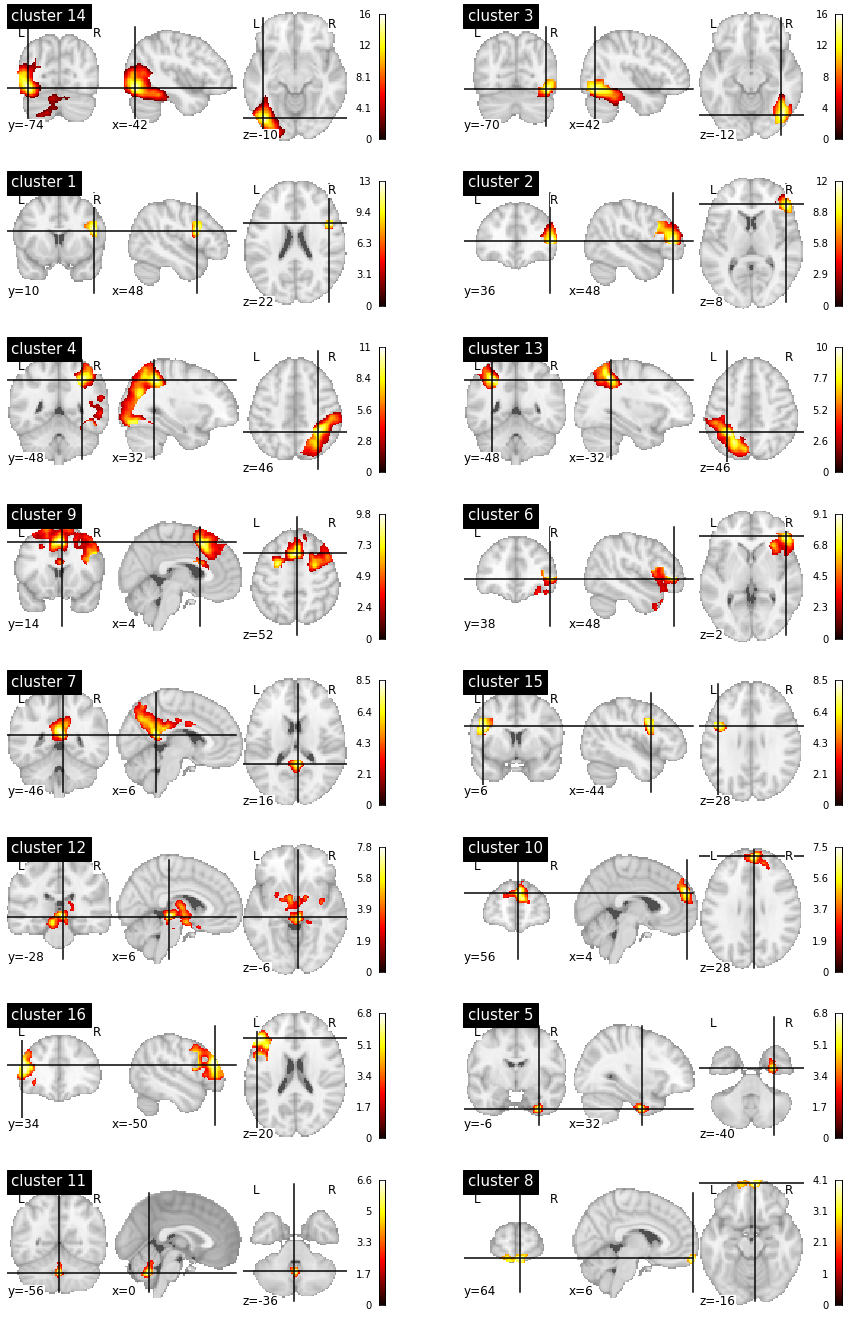

In [8]:
nrows = int(np.ceil(len(positive_peaks_0001)/2))
height_size = 3*nrows
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(15, height_size))
axs= axs.flatten()
for ii, peak_id in enumerate(np.argsort(positive_peaks_0001)[::-1]):
    cluster_img = image.index_img(positive_regions_0001_img, peak_id)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
    
    plotting.plot_stat_map(image.index_img(positive_regions_0001_img, peak_id), 
                           cut_coords=coords_cluster,
                           title = "cluster %d" % (peak_id+1), 
                           cmap=plotting.cm.cold_hot, 
                           axes=axs[ii])
    
for kk in range(ii, 2*nrows):
    axs[kk].set_axis_off()

In [9]:
for ii in np.argsort(negative_peaks_0001)[::-1]:
    cluster_img = image.index_img(negative_regions_0001_img, ii)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
    
    n_voxels = (cluster_img.get_fdata()!=0).sum()
    t_max = cluster_img.get_fdata().max()
    print("negative cluster %d, has %d voxels, the peak coordinates " % (ii+1, n_voxels), 
          np.round(coords_cluster), "and min peak: %.2f" % (-t_max))

negative cluster 6, has 11139 voxels, the peak coordinates  [  6. -74.  -2.] and min peak: -11.15
negative cluster 9, has 7062 voxels, the peak coordinates  [-54. -16.  48.] and min peak: -10.92
negative cluster 8, has 7589 voxels, the peak coordinates  [-20. -28.  70.] and min peak: -8.85
negative cluster 2, has 901 voxels, the peak coordinates  [ 50. -12.  48.] and min peak: -8.41
negative cluster 1, has 5934 voxels, the peak coordinates  [54. -2.  4.] and min peak: -8.18
negative cluster 5, has 483 voxels, the peak coordinates  [ 22. -24.  62.] and min peak: -8.17
negative cluster 4, has 1832 voxels, the peak coordinates  [ 32. -84. -34.] and min peak: -7.55
negative cluster 7, has 2536 voxels, the peak coordinates  [  0.  48. -10.] and min peak: -6.15
negative cluster 3, has 181 voxels, the peak coordinates  [42. 60. -8.] and min peak: -4.74


In [10]:
# Create information table 
neg_info_0001_df = create_table_from_peaks(negative_regions_0001_img, negative_peaks_0001)
neg_info_0001_df.iloc[:, 6] = -neg_info_0001_df.iloc[:, 6] # Display peaks in negative
neg_info_0001_df.to_excel("../results/group-level-maps/lookNeg_vs_lookNeut/negative_activations_fdr05_k50.xlsx",
                         index=False)
neg_info_0001_df

,Hemisphere,Region,x,y,z,Voxels,Peak (t-value)
0,R,Lingual_Gyrus,6,-74,-2,11139,-11.15
1,L,Postcentral_Gyrus,-54,-16,48,7062,-10.92
2,L,Precentral_Gyrus,-20,-28,70,7589,-8.85
3,R,Precentral_Gyrus,50,-12,48,901,-8.41
4,R,Superior_Temporal_Gyrus,54,-2,4,5934,-8.18
5,R,Precentral_Gyrus,22,-24,62,483,-8.17
6,R,Uvula,32,-84,-34,1832,-7.55
7,L,Unknown,0,48,-10,2536,-6.15
8,R,Middle_Frontal_Gyrus,42,60,-8,181,-4.74


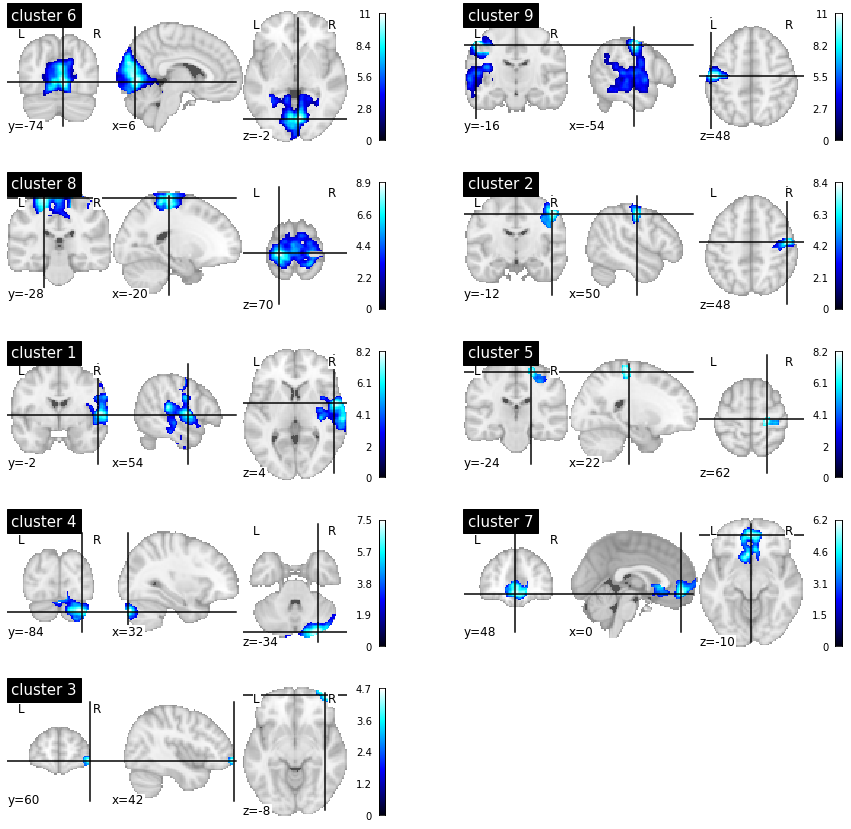

In [11]:
nrows = int(np.ceil(len(negative_peaks_0001)/2))
height_size = 3*nrows
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(15, height_size))
axs= axs.flatten()
for ii, peak_id in enumerate(np.argsort(negative_peaks_0001)[::-1]):
    cluster_img = image.index_img(negative_regions_0001_img, peak_id)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
    
    plotting.plot_stat_map(image.index_img(negative_regions_0001_img, peak_id), 
                           cut_coords=coords_cluster,
                           title = "cluster %d" % (peak_id+1), 
                           cmap=plotting.cm.cold_hot_r, 
                           axes=axs[ii])
    
for kk in range(ii, 2*nrows):
    axs[kk].set_axis_off()

# REGULATE NEGATIVE vs LOOK NEGATIVE

In [12]:
t_map_0002_thr = image.load_img("../results/group-level-maps/RegNeg_vs_lookNeg/RegNeg_vs_lookNeg_fdr05_k50.nii.gz")

In [13]:
# Clusters around the peak
positive_regions_0002_img, index_pos_0002 = connected_regions(t_map_0002_thr)
negative_regions_0002_img, index_neg_0002 = connected_regions(image.math_img("-1*img1", img1=t_map_0002_thr))

# The peaks
positive_peaks_0002 = [image.index_img(positive_regions_0002_img, ii).get_fdata().max() for \
                      ii in range(len(index_pos_0002))]
negative_peaks_0002 = [image.index_img(negative_regions_0002_img, ii).get_fdata().max() for \
                      ii in range(len(index_neg_0002))]

In [14]:
for ii in np.argsort(positive_peaks_0002)[::-1]:
    cluster_img = image.index_img(positive_regions_0002_img, ii)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
    
    n_voxels = (cluster_img.get_fdata()!=0).sum()
    t_max = cluster_img.get_fdata().max()
    
    print("positive cluster %d, has %d voxels and the peak coordinates" % (ii+1, n_voxels), 
          np.round(coords_cluster), "and max peak: %.2f" % (t_max))

positive cluster 12, has 2196 voxels and the peak coordinates [-54. -58.  38.] and max peak: 7.01
positive cluster 1, has 1402 voxels and the peak coordinates [ 52. -48.  32.] and max peak: 6.08
positive cluster 2, has 431 voxels and the peak coordinates [ 50. -28.  -6.] and max peak: 5.92
positive cluster 8, has 707 voxels and the peak coordinates [-36. -62. -28.] and max peak: 5.74
positive cluster 7, has 391 voxels and the peak coordinates [ -10. -102.   18.] and max peak: 5.54
positive cluster 5, has 1423 voxels and the peak coordinates [ 32. -64. -28.] and max peak: 5.49
positive cluster 9, has 532 voxels and the peak coordinates [-36.   4.  54.] and max peak: 5.17
positive cluster 6, has 402 voxels and the peak coordinates [ 6. 38. 52.] and max peak: 4.88
positive cluster 11, has 406 voxels and the peak coordinates [-50. -16. -34.] and max peak: 4.74
positive cluster 10, has 470 voxels and the peak coordinates [-48.  20.  -8.] and max peak: 4.72
positive cluster 3, has 275 voxels

In [15]:
# Create information table 
pos_info_0002_df = create_table_from_peaks(positive_regions_0002_img, positive_peaks_0002)
pos_info_0002_df.to_excel("../results/group-level-maps/RegNeg_vs_lookNeg/positive_activations_fdr05_k50.xlsx",
                         index=False)
pos_info_0002_df

,Hemisphere,Region,x,y,z,Voxels,Peak (t-value)
0,L,Inferior_Parietal_Lobule,-54,-58,38,2196,7.01
1,R,Supramarginal_Gyrus,52,-48,32,1402,6.08
2,R,Middle_Temporal_Gyrus,50,-28,-6,431,5.92
3,L,Declive,-36,-62,-28,707,5.74
4,L,Cuneus,-10,-102,18,391,5.54
5,R,Declive,32,-64,-28,1423,5.49
6,L,Middle_Frontal_Gyrus,-36,4,54,532,5.17
7,R,Superior_Frontal_Gyrus,6,38,52,402,4.88
8,L,Inferior_Temporal_Gyrus,-50,-16,-34,406,4.74
9,L,Inferior_Frontal_Gyrus,-48,20,-8,470,4.72


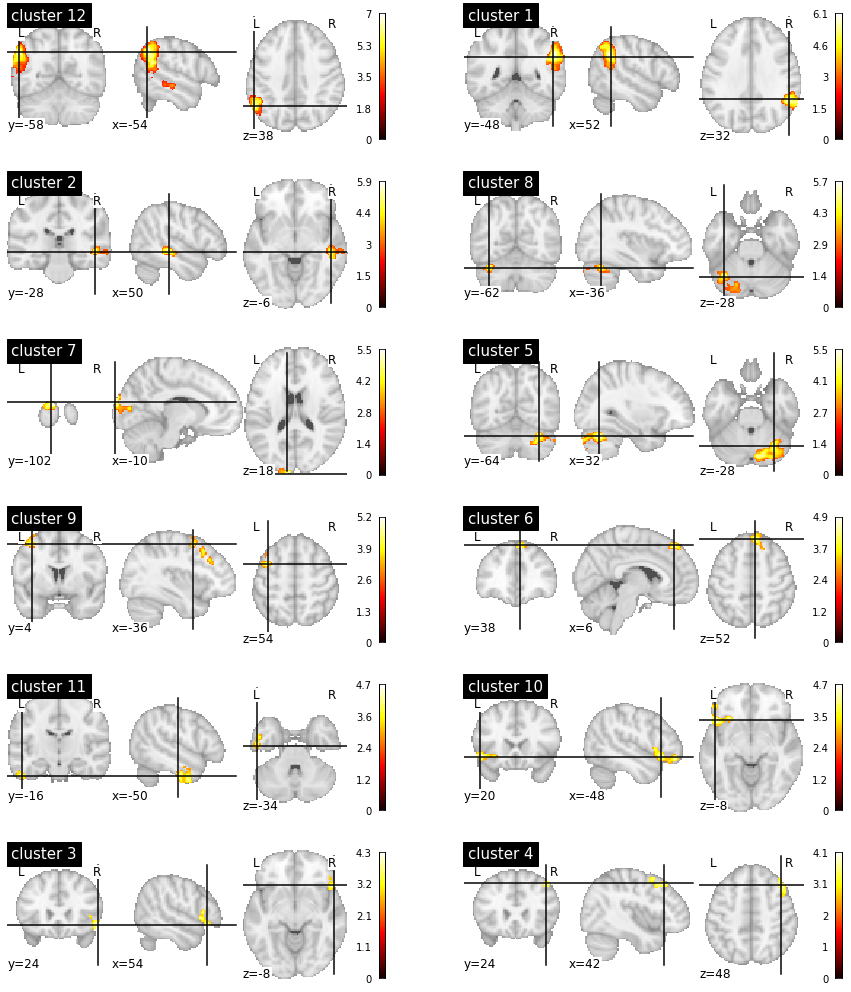

In [16]:
nrows = int(np.ceil(len(positive_peaks_0002)/2))
height_size = 3*nrows
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(15, height_size))
axs= axs.flatten()
for ii, peak_id in enumerate(np.argsort(positive_peaks_0002)[::-1]):
    cluster_img = image.index_img(positive_regions_0002_img, peak_id)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
      
    plotting.plot_stat_map(image.index_img(positive_regions_0002_img, peak_id), 
                           cut_coords=coords_cluster,
                           title = "cluster %d" % (peak_id+1),
                           cmap=plotting.cm.cold_hot, 
                           axes=axs[ii])
    
for kk in range(ii, 2*nrows):
    axs[kk].set_axis_off()

In [17]:
for ii in np.argsort(negative_peaks_0002)[::-1]:
    cluster_img = image.index_img(negative_regions_0002_img, ii)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
    
    n_voxels = (cluster_img.get_fdata()!=0).sum()
    t_max = cluster_img.get_fdata().max()
    
    print("negative cluster %d, has %d voxels and the peak coordinates" % (ii+1, n_voxels), 
          np.round(coords_cluster), "and max peak: %.2f" % (-t_max))

negative cluster 10, has 3549 voxels and the peak coordinates [-34. -20.  70.] and max peak: -6.83
negative cluster 11, has 1644 voxels and the peak coordinates [-44. -70.  -6.] and max peak: -6.34
negative cluster 1, has 2700 voxels and the peak coordinates [ 60. -16.  38.] and max peak: -6.27
negative cluster 2, has 1412 voxels and the peak coordinates [ 48. -68.  -6.] and max peak: -6.25
negative cluster 12, has 1641 voxels and the peak coordinates [-60. -20.  42.] and max peak: -6.22
negative cluster 5, has 1770 voxels and the peak coordinates [ 28. -40.  62.] and max peak: -5.96
negative cluster 8, has 290 voxels and the peak coordinates [-6. 52. 24.] and max peak: -5.58
negative cluster 7, has 943 voxels and the peak coordinates [ 4. -6. 56.] and max peak: -5.51
negative cluster 3, has 268 voxels and the peak coordinates [50. 38. 14.] and max peak: -5.14
negative cluster 9, has 696 voxels and the peak coordinates [-10.  50. -10.] and max peak: -5.08
negative cluster 6, has 264 vo

In [18]:
# Create information table 
neg_info_0002_df = create_table_from_peaks(negative_regions_0002_img, negative_peaks_0002)
neg_info_0002_df.iloc[:, 6] = -neg_info_0002_df.iloc[:, 6] # Display peaks in negative
neg_info_0002_df.to_excel("../results/group-level-maps/RegNeg_vs_lookNeg/negative_activations_fdr05_k50.xlsx",
                         index=False)
neg_info_0002_df

,Hemisphere,Region,x,y,z,Voxels,Peak (t-value)
0,L,Precentral_Gyrus,-34,-20,70,3549,-6.83
1,L,Sub_Gyral,-44,-70,-6,1644,-6.34
2,R,Precentral_Gyrus,60,-16,38,2700,-6.27
3,R,Inferior_Temporal_Gyrus,48,-68,-6,1412,-6.25
4,L,Precentral_Gyrus,-60,-20,42,1641,-6.22
5,R,Postcentral_Gyrus,28,-40,62,1770,-5.96
6,L,Medial_Frontal_Gyrus,-6,52,24,290,-5.58
7,R,Medial_Frontal_Gyrus,4,-6,56,943,-5.51
8,R,Inferior_Frontal_Gyrus,50,38,14,268,-5.14
9,L,Medial_Frontal_Gyrus,-10,50,-10,696,-5.08


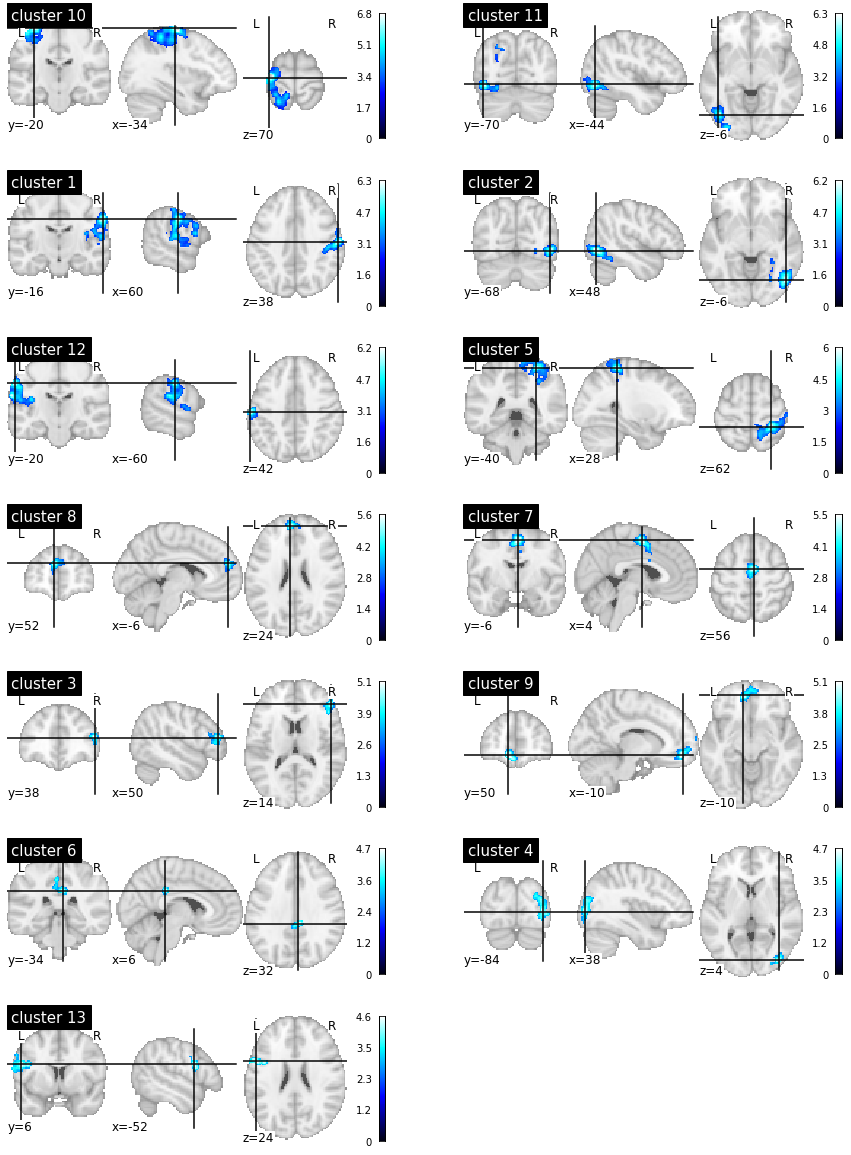

In [19]:
nrows = int(np.ceil(len(negative_peaks_0002)/2))
height_size = 3*nrows
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(15, height_size))
axs= axs.flatten()
for ii, peak_id in enumerate(np.argsort(negative_peaks_0002)[::-1]):
    cluster_img = image.index_img(negative_regions_0002_img, peak_id)
    
    a,b,c = np.argwhere(cluster_img.get_fdata()==np.max(cluster_img.get_fdata())).flatten()
    coords_cluster = coord_transform(a,b, c, affine=cluster_img.affine)
    
    plotting.plot_stat_map(image.index_img(negative_regions_0002_img, peak_id), 
                           cut_coords=coords_cluster,
                           title = "cluster %d" % (peak_id+1), 
                           cmap=plotting.cm.cold_hot_r, 
                           axes=axs[ii])
    
for kk in range(ii, 2*nrows):
    axs[kk].set_axis_off()